In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

In [2]:
import math

def entropy( x, b ):
    s = 0
    for p in x:
        if p > 0:
            s += -p*math.log(p,b)
        # end
    # end
    return s
# end

def visualize_regions(model, MAX, nGrid):
    a1 = np.linspace(-MAX, MAX, nGrid)
    a2 = np.linspace(-MAX, MAX, nGrid)

    A1, A2 = np.meshgrid(a1, a2)
    A1 = A1.flatten()
    A2 = A2.flatten()
    A = np.vstack((A1, A2)).T

    # Predict B
    B = model.predict(A)
    B = B.reshape(nGrid, nGrid)
    B = np.flipud(B)

    # Compute entropy for S
    prob_2D = model.predict_proba(A)
    S = np.array([entropy(p, 2) for p in prob_2D])
    S = S.reshape(nGrid, nGrid)
    S = np.flipud(S)

    return B, S
# end

## Create data

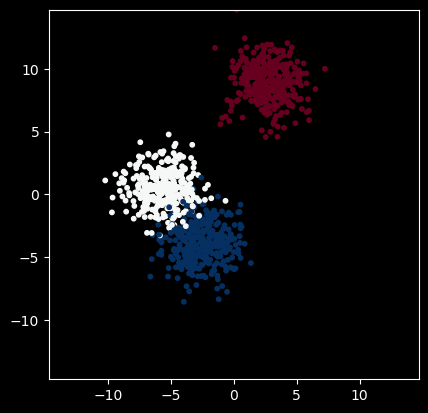

C:\Users\Graham West\anaconda3\envs\csci4900\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


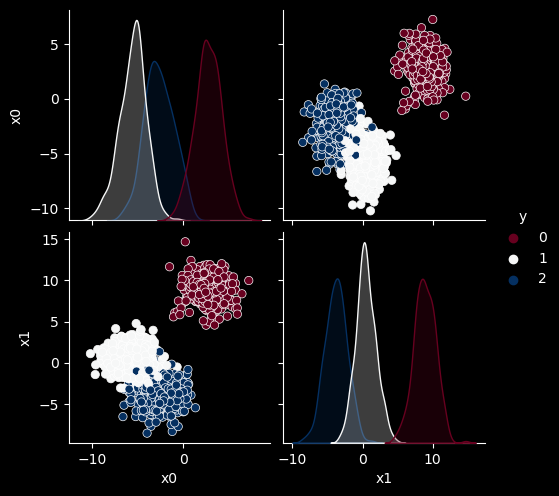

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(
    n_samples=1000,
    n_features=2,
    centers=3,
    cluster_std=1.5,
    random_state=1
)

X = X - X.mean()

MAX = np.max(np.abs(X))

plt.scatter(X[:,0], X[:,1], c=y, s=10, cmap="RdBu");
plt.xlim(-MAX,MAX)
plt.ylim(-MAX,MAX)
plt.gca().set_aspect('equal')
plt.show()

df = pd.DataFrame( {"x0":X[:,0], "x1":X[:,1], "y":y} )
sns.pairplot(df, hue='y', palette='RdBu')
plt.show()

## Modeling

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y
)

In [5]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=100, max_leaf_nodes=3)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train).astype(int)
y_test_pred  = model.predict(X_test).astype(int)

## Analysis

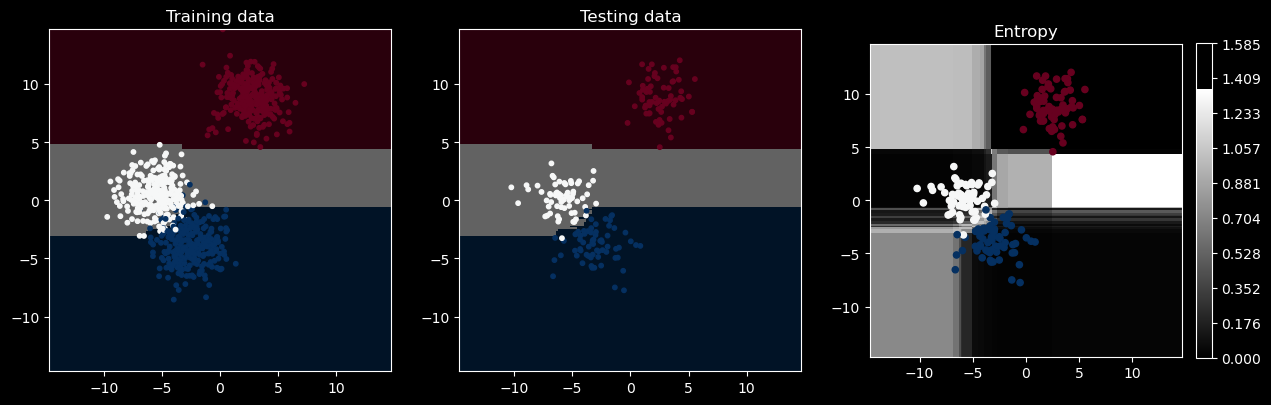

In [6]:
B, S = visualize_regions(model, MAX, 200)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

extent = [-MAX,MAX,-MAX,MAX]

cmap = "RdBu"
axes[0].imshow(B, interpolation='none', extent=extent,cmap=cmap, alpha=0.4)
axes[0].scatter(X_train[:,0], X_train[:,1], c=y_train, s=10, cmap=cmap);
axes[0].set_aspect('equal')
axes[0].set_title('Training data');

axes[1].imshow(B, interpolation='none', extent=extent,cmap=cmap, alpha=0.4)
axes[1].scatter(X_test[:,0], X_test[:,1], c=y_test, s=10, cmap=cmap);
axes[1].set_aspect('equal')
axes[1].set_title('Testing data');

im = axes[2].imshow(S, interpolation='none', extent=extent,cmap='gray')
axes[2].scatter(X_test[:,0], X_test[:,1], c=y_test, s=20, cmap=cmap);
axes[2].set_aspect('equal')
axes[2].set_title('Entropy')
cbar = fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
cbar.set_ticks(np.linspace(0, math.log(y.max()+1,2), 10))

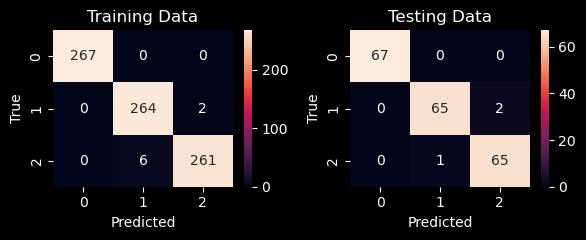

In [7]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrices
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Create subplots for side-by-side visualization
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2.5))

# Plot confusion matrix for training data
sns.heatmap(conf_matrix_train, annot=True, vmin=0, fmt='d', ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_title("Training Data")

# Plot confusion matrix for test data
sns.heatmap(conf_matrix_test, annot=True, vmin=0, fmt='d', ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_title("Testing Data")

# Show the plots
plt.tight_layout()
plt.show()

In [8]:
conf_matrix_train = conf_matrix_train.astype(float)
conf_matrix_test  = conf_matrix_test.astype(float)
for i in range(conf_matrix_train.shape[0]):
    conf_matrix_train[i,:] = conf_matrix_train[i,:] / conf_matrix_train[i,:].sum()
    conf_matrix_test[i,:]  = conf_matrix_test[i,:] / conf_matrix_test[i,:].sum()
# end

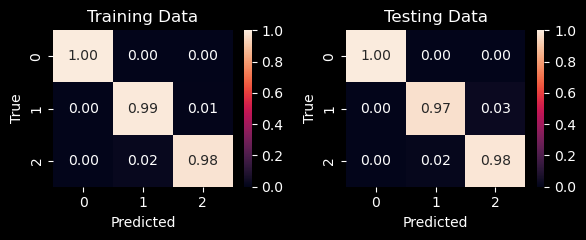

In [9]:
# Create subplots for side-by-side visualization
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2.5))

# Plot confusion matrix for training data
sns.heatmap(conf_matrix_train, annot=True, vmin=0, fmt='.2f', ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_title("Training Data")

# Plot confusion matrix for test data
sns.heatmap(conf_matrix_test, annot=True, vmin=0, fmt='.2f', ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_title("Testing Data")

# Show the plots
plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import classification_report

print("Training Data:")
print(classification_report(y_train, y_train_pred))
print()
print("Testing Data:")
print(classification_report(y_test, y_test_pred))

Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       267
           1       0.98      0.99      0.99       266
           2       0.99      0.98      0.98       267

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800


Testing Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       0.98      0.97      0.98        67
           2       0.97      0.98      0.98        66

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200

